In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from data.raw.professions import df_female, df_male


# Vergleichswerte
Als Vergleichswerte verwenden wir die Werte aus dem df_female und df_male. Diese beiden Dataframes fügen wir in df_real zusammen.

In [2]:
df_real = pd.concat([df_female, df_male], ignore_index=True)
df_real.head()

,job,percent_female
0,Nurse,86.8
1,Kindergarten Teacher,96.8
2,Flight Attendant,77.2
3,Administrative Assistant,91.4
4,Dental Hygienist,93.9


# Analyse des df_neutral

In [30]:
# CSV laden
df = pd.read_csv("../data/processed/translated_df_neutral_cleaned.csv")

## grouped_df
Wir gruppieren den Dataframe nach:
"job1", "gender_job1_extracted", "job2", "gender_job2_extracted", "verb_category"
und summieren über die Auftrittshäufigkeiten der Kombinationen in der Spalte "count"

In [31]:
#Wähle nur die relevanten Spalten aus
df_subset = df[[
    "job1", "gender_job1_extracted",
    "job2", "gender_job2_extracted",
    "verb_category"
]]

# Gruppiere nach einzigartigen Kombinationen aus Beruf, Geschlecht und Verb-Kategorie
# und zähle, wie oft jede Kombination im Datensatz vorkommt
grouped_df = (
    df_subset
    .groupby([
        "job1", "gender_job1_extracted",
        "job2", "gender_job2_extracted",
        "verb_category"
    ])
    .size()                     # Zählt die Zeilen pro Kombination
    .reset_index(name="count")  # Zählt-Spalte benennen und GroupBy-Ergebnis in ein DataFrame umwandeln
    )


# Preview result
print(grouped_df.head())

                       job1 gender_job1_extracted                      job2  \
0  Administrative Assistant                female  Administrative Assistant   
1  Administrative Assistant                female  Administrative Assistant   
2  Administrative Assistant                female  Administrative Assistant   
3  Administrative Assistant                female              Car Mechanic   
4  Administrative Assistant                female              Car Mechanic   

  gender_job2_extracted verb_category  count  
0                female        caring      5  
1                female      dominant      5  
2                female       neutral      5  
3                  male        caring      5  
4                  male      dominant      5  


## gender_counts_df
Im folgenden Schritt aggregieren wir die Häufigkeiten der Geschlechterzuweisungen für die Berufe aus den Spalten job1 und job2. Dabei werden die Zählungen für gleiche Berufe und Geschlechter zusammengeführt, um die Gesamtverteilung pro Beruf und Geschlecht zu erhalten.

Anschließend erweitern wir diese aggregierten Daten um die realen Frauenanteile (percent_female) aus einem externen Datensatz df_real. Für die männlichen Anteile wird der entsprechende Wert als 100% - percent_female berechnet.

Das Ergebnis ist ein DataFrame, das sowohl die extrahierten Geschlechteranteile aus dem Datensatz als auch die realen Geschlechterverteilungen pro Beruf enthält. Dieser DataFrame kann anschließend für vergleichende Visualisierungen verwendet werden.

In [32]:
# 1. Summiere Häufigkeiten für job1 nach job und geschlecht
gender_counts_job1_df = (
    grouped_df
    .groupby(["job1", "gender_job1_extracted"])["count"]
    .sum()
    .reset_index()
    .rename(columns={"job1": "job", "gender_job1_extracted": "gender", "count": "count"})
)

# 2. Summiere Häufigkeiten für job2 nach job und geschlecht
gender_counts_job2_df = (
    grouped_df
    .groupby(["job2", "gender_job2_extracted"])["count"]
    .sum()
    .reset_index()
    .rename(columns={"job2": "job", "gender_job2_extracted": "gender", "count": "count"})
)

# 3. Füge die beiden zusammen und summiere die counts pro job und gender
gender_counts_df = pd.concat([gender_counts_job1_df, gender_counts_job2_df], ignore_index=True)

gender_counts_df = (
    gender_counts_df
    .groupby(["job", "gender"])["count"]
    .sum()
    .reset_index()
)

# 4. Berechne Prozentwerte pro Job
total_counts_per_job = gender_counts_df.groupby("job")["count"].transform("sum")
gender_counts_df["percentage"] = gender_counts_df["count"] / total_counts_per_job * 100

# "team" aus dem DataFrame entfernen (nicht als echter Beruf)
gender_counts_df = gender_counts_df[gender_counts_df["job"] != "team"]

# Preview
print(gender_counts_df.head())

                        job  gender  count  percentage
0  Administrative Assistant  female    590   95.934959
1  Administrative Assistant    male     25    4.065041
2              Car Mechanic    male    615  100.000000
3            Civil Engineer    male    615  100.000000
4       Construction Worker    male    614  100.000000


In [33]:
# ==============================================================================
#  Vollständige Matrix aller job × gender-Kombis erzeugen
# ==============================================================================

# Alle Jobs aus df_real
all_jobs = df_real["job"].unique()
all_genders = ["male", "female"]
full_index = pd.MultiIndex.from_product([all_jobs, all_genders], names=["job", "gender"])
full_df = pd.DataFrame(index=full_index).reset_index()

# 4. Mergen mit beobachteten counts
gender_counts_df = full_df.merge(gender_counts_df, on=["job", "gender"], how="left")
gender_counts_df["count"] = gender_counts_df["count"].fillna(0)

# 5. Prozentwerte berechnen
total_counts = gender_counts_df.groupby("job")["count"].transform("sum")
# Achtung: Vermeide Division durch 0
gender_counts_df["percentage"] = np.where(total_counts > 0,
                                          gender_counts_df["count"] / total_counts * 100,
                                          0)

In [34]:
# 1. df_real so vorbereiten, dass wir für jedes Geschlecht Prozentwerte haben
# A) Für Frauen: percent_female aus df_real
df_real_female = df_real[["job", "percent_female"]].copy()
df_real_female["gender"] = "female"
df_real_female = df_real_female.rename(columns={"percent_female": "real_percentage"})

# B) Für Männer: 100 - percent_female
df_real_male = df_real[["job", "percent_female"]].copy()
df_real_male["gender"] = "male"
df_real_male["real_percentage"] = 100 - df_real_male["percent_female"]

# Beide zusammenfügen
df_real_expanded = pd.concat([df_real_female, df_real_male], ignore_index=True)[["job", "gender", "real_percentage"]]

# 2. Mit gender_counts_df joinen (linker Join auf job und gender)
gender_counts_df = gender_counts_df.merge(df_real_expanded, on=["job", "gender"], how="left")

# Preview
print(gender_counts_df.head())

                    job  gender  count  percentage  real_percentage
0                 Nurse    male    0.0         0.0             13.2
1                 Nurse  female  615.0       100.0             86.8
2  Kindergarten Teacher    male    0.0         0.0              3.2
3  Kindergarten Teacher  female  614.0       100.0             96.8
4      Flight Attendant    male    0.0         0.0             22.8


## Grafische Auswertung

In [35]:
print(gender_counts_df["gender"].unique())

['male' 'female']


### Prozentuale Gender-Zuweisung pro Beruf
Dieses Balkendiagramm vergleicht die prozentuale Gender-Zuweisung pro Beruf zwischen:
- **extrahierten Werten** aus dem Textkorpus (gefüllte Balken)
- und den **realen Verteilungen** (gestrichelte Umrisse), z. B. aus statistischen Erhebungen.

Die Farben zeigen das Geschlecht: **Rot = Frauen**, **Blau = Männer**.

Dadurch wird ersichtlich, ob bestimmte Berufe im Korpus stereotyp über- oder unterrepräsentiert sind.

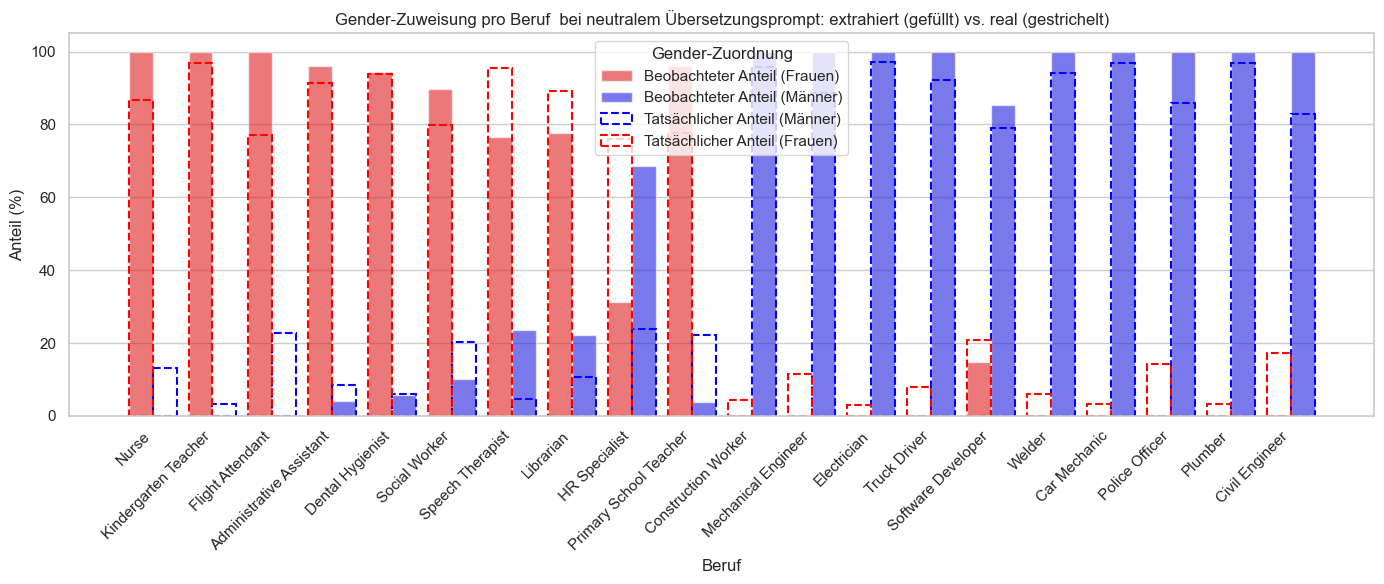

In [64]:
#------------------------------------------------------------
# Plot
#------------------------------------------------------------

# Farbpalette
palette = {"female": "red", "male": "blue"}
genders = ["female", "male"]
jobs_sorted = gender_counts_df["job"].unique()

plt.figure(figsize=(14, 6))

# A) Extrahierte Werte – gefüllte Balken
barplot = sns.barplot(
    data=gender_counts_df,
    x="job",
    y="percentage",
    hue="gender",
    palette=palette,
    order=jobs_sorted,
    hue_order=genders,
    dodge=True
)
# Mache die Balken transparent(er), z. B. alpha = 0.4
for patch in barplot.patches:
    patch.set_alpha(0.6)

# B) Reale Werte – gestrichelte Balken mit Umrandung
for i, row in gender_counts_df.iterrows():
    xpos = list(jobs_sorted).index(row["job"])
    offset = -0.2 if row["gender"] == "female" else 0.2
    plt.bar(
        xpos + offset,
        row["real_percentage"],
        width=0.4,
        color="none",
        edgecolor=palette[row["gender"]],
        linestyle="--",
        linewidth=1.5,
        label=f"real {row['gender']}" if i < 2 else None  # Nur 1× in Legende
    )

# Achsen und Layout
plt.title("Gender-Zuweisung pro Beruf  bei neutralem Übersetzungsprompt: extrahiert (gefüllt) vs. real (gestrichelt)")
plt.ylabel("Anteil (%)")
plt.xlabel("Beruf")
plt.xticks(ticks=range(len(jobs_sorted)), labels=jobs_sorted, rotation=45, ha="right")

# Legende: Duplikate entfernen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Übersetze die legende
de_labels = {
    "female": "Beobachteter Anteil (Frauen)",
    "male": "Beobachteter Anteil (Männer)",
    "real female": "Tatsächlicher Anteil (Frauen)",
    "real male": "Tatsächlicher Anteil (Männer)"
}

plt.legend(by_label.values(), [de_labels[key] for key in by_label.keys()], title="Gender-Zuordnung")

plt.tight_layout()

# Speichern
plt.savefig("../plots/Histogram_gender_job_df_neutral_plus_real_percentage.png", dpi=300)


plt.show()

### Gender-Zuweisung pro Beruf und Verbgruppe
Diese Visualisierung zeigt die Verteilung der Geschlechterzuweisungen (female, male) für verschiedene Berufe („Jobs“) in unserem Datensatz, differenziert nach Verbkategorien („caring“, „dominant“, „neutral“). Ziel ist es, sowohl die beobachteten Anteile aus den Daten als auch die tatsächlichen Referenzwerte (realistische Prozentsätze) gegenüberzustellen.

- Vorgehensweise

   Für jeden Beruf werden drei Balken dargestellt:

    - Anteil der Geschlechterzuweisung bei der Verbkategorie caring

    - Anteil der Geschlechterzuweisung bei der Verbkategorie dominant

    - Anteil der Geschlechterzuweisung bei der Verbkategorie neutral

   Die Balken sind nach Geschlecht (female, male) farblich unterschieden.

   Zusätzlich zeigen gestrichelte vertikale Linien die tatsächlichen, realen Geschlechteranteile für jeden Beruf und jedes Geschlecht als Referenz.

   Die Berufe sind horizontal aufgelistet, wobei für bessere Lesbarkeit die Verbkategorien gruppiert und visuell getrennt sind.

- Zweck

    Diese Darstellung ermöglicht es, Unterschiede und Muster in der geschlechtlichen Zuweisung von Berufen in Abhängigkeit von unterschiedlichen Verbkategorien zu erkennen und mit den realen Geschlechteranteilen zu vergleichen. So lässt sich z.B. untersuchen, ob bestimmte Verben wie „caring“ oder „dominant“ zu einer verzerrten Wahrnehmung von Geschlechtern bei bestimmten Berufen führen.

#### Datenvorbereitung

In [50]:
# Gruppieren & Summe der Counts pro (job, gender, verb_category)
gender_counts_job1_verb = (
    grouped_df[grouped_df["job1"] != "team"]
    .groupby(["job1", "gender_job1_extracted", "verb_category"])["count"]
    .sum()
    .reset_index()
    .rename(columns={"job1": "job", "gender_job1_extracted": "gender"})
)

# Erstelle kompletten Index aller Kombinationen
jobs = df_real["job"].unique()
genders = ["female", "male"]
verb_categories = grouped_df["verb_category"].unique()

full_index = pd.MultiIndex.from_product([jobs, genders, verb_categories], names=["job", "gender", "verb_category"])
full_df = pd.DataFrame(index=full_index).reset_index()

# Merge & NAs mit 0 füllen
gender_counts_full = full_df.merge(gender_counts_job1_verb, on=["job", "gender", "verb_category"], how="left")
gender_counts_full["count"] = gender_counts_full["count"].fillna(0)

# Summe der Counts pro (job, verb_category) berechnen
total_counts = gender_counts_full.groupby(["job", "verb_category"])["count"].transform("sum")

# Prozentwerte berechnen (nur wenn Summe > 0)
gender_counts_full["percentage"] = gender_counts_full.apply(
    lambda row: (row["count"] / total_counts.loc[row.name] * 100) if total_counts.loc[row.name] > 0 else 0,
    axis=1
)

gender_counts_full.head()

,job,gender,verb_category,count,percentage
0,Nurse,female,caring,105.0,100.0
1,Nurse,female,dominant,105.0,100.0
2,Nurse,female,neutral,105.0,100.0
3,Nurse,male,caring,0.0,0.0
4,Nurse,male,dominant,0.0,0.0


In [51]:
# Realwerte vorbereiten
df_real_female = df_real[["job", "percent_female"]].copy()
df_real_female["gender"] = "female"
df_real_female = df_real_female.rename(columns={"percent_female": "real_percentage"})

df_real_male = df_real[["job", "percent_female"]].copy()
df_real_male["gender"] = "male"
df_real_male["real_percentage"] = 100 - df_real_male["percent_female"]

df_real_expanded = pd.concat([df_real_female, df_real_male], ignore_index=True)[["job", "gender", "real_percentage"]]

# Merge real_percentage zu gender_counts_full
gender_counts_full = gender_counts_full.merge(df_real_expanded, on=["job", "gender"], how="left")
gender_counts_full.head()

,job,gender,verb_category,count,percentage,real_percentage
0,Nurse,female,caring,105.0,100.0,86.8
1,Nurse,female,dominant,105.0,100.0,86.8
2,Nurse,female,neutral,105.0,100.0,86.8
3,Nurse,male,caring,0.0,0.0,13.2
4,Nurse,male,dominant,0.0,0.0,13.2


#### Plot

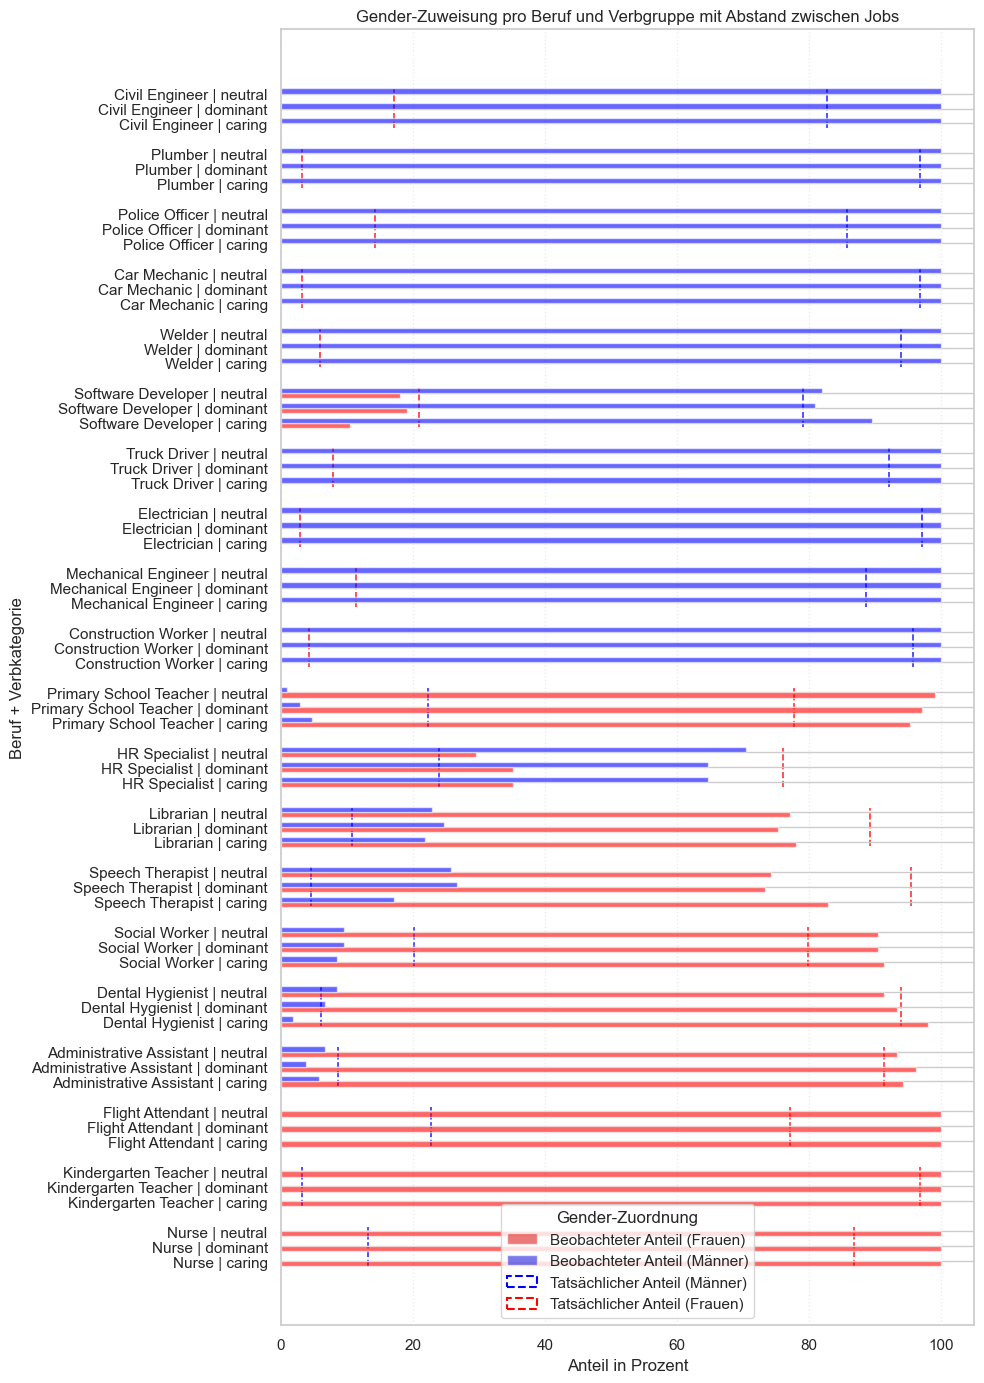

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Gruppiere nach job, gender, verb_category - deine DataFrame ist gender_counts_full

# Erstelle neue numerische y-Positionen mit Lücken
jobs = gender_counts_full["job"].unique()
job_cat_spaced = []
y_positions = []
pos = 0

for job in jobs:
    job_cats = gender_counts_full[gender_counts_full["job"] == job]["job_cat"].unique()
    for cat in job_cats:
        job_cat_spaced.append(cat)
        y_positions.append(pos)
        pos += 1
    pos += 1  # Lücke

# Mapping job_cat -> y_pos
job_cat_to_y = dict(zip(job_cat_spaced, y_positions))

# Plot Setup
plt.figure(figsize=(10, 14))

# Barbreite etwas schmaler, Balken nebeneinander für gender (male/female)
bar_height = 0.35

for gender_idx, gender in enumerate(["female", "male"]):
    df_gender = gender_counts_full[gender_counts_full["gender"] == gender]
    x_vals = df_gender["percentage"].values
    y_vals = np.array(df_gender["job_cat"].map(job_cat_to_y).values, dtype=float)
    y_offset = bar_height * (gender_idx - 0.5)

    plt.barh(
        y_vals + y_offset,
        x_vals,
        height=bar_height,
        color=palette[gender],
        alpha=0.6,
        label=gender if gender_idx == 0 else None
    )

# Referenzlinien für reale Werte (pro job/gender)
for (job, gender), group in gender_counts_full.groupby(["job", "gender"]):
    real_val = group["real_percentage"].iloc[0]
    if pd.notna(real_val):
        job_cats = group["job_cat"].tolist()
        y_pos = [job_cat_to_y[cat] for cat in job_cats]
        y_min = min(y_pos) - 0.3
        y_max = max(y_pos) + 0.3

        plt.plot(
            [real_val, real_val],
            [y_min, y_max],
            color=palette[gender],
            linestyle="dashed",
            linewidth=1.2,
            alpha=0.8,
            zorder=0
        )

# Achsen und Labels
plt.yticks(ticks=y_positions, labels=job_cat_spaced)
plt.xlabel("Anteil in Prozent")
plt.ylabel("Beruf + Verbkategorie")
plt.title("Gender-Zuweisung pro Beruf und Verbgruppe mit Abstand zwischen Jobs")

# Übersetze die legende
de_labels = {
    "female": "Beobachteter Anteil (Frauen)",
    "male": "Beobachteter Anteil (Männer)",
    "real female": "Tatsächlicher Anteil (Frauen)",
    "real male": "Tatsächlicher Anteil (Männer)"
}

plt.legend(by_label.values(), [de_labels[key] for key in by_label.keys()], title="Gender-Zuordnung")

plt.grid(axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()

# Speichern
plt.savefig("../plots/Histogram_gender_job_by_verbcat_df_neutral_plus_real_percentage_var.png", dpi=300)

plt.show()

